# Potato balances

In this notebook we will use the partial least squares balances to quantify differences between potato cultivars.

In [1]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from gneiss.util import match

from pls_balances.src.balances import balance_classify, round_balance
import qiime2
import numpy as np
import matplotlib

%matplotlib inline
np.random.seed(0)
#font = {'family' : 'norma
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [2]:
data_dir = '../data/potato_pls_wip/data'
table_file = '%s/openms_noise5k/ft-w-gnpsid-norm-hdf5.biom.qza' % data_dir
metadata_file = '%s/potato_untargeted_metabolomics_metadata.txt' % data_dir

table = qiime2.Artifact.load(table_file).view(pd.DataFrame)
metadata = pd.read_table(metadata_file, index_col=0)

table, metadata = match(table, metadata)

# set the colors
purple_color = '#A569BD' 
white_color = '#B3B6B7' 
red_color = '#F1948A' 

We'll want to first apply standard PLS to see if there are really obvious patterns.

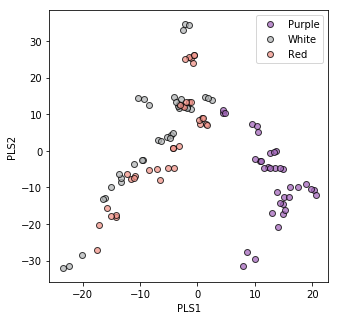

In [3]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement

fig, ax = plt.subplots(figsize=(5, 5))

class_purple = (metadata.cultivar_color == 'Purple').values
class_white = (metadata.cultivar_color == 'White').values
class_red = (metadata.cultivar_color == 'Red').values

Y = np.vstack((class_purple, 
               np.logical_or(class_red, class_white))).astype(np.int).T

potato_pls = PLSRegression(n_components=2)
#table = pd.DataFrame(multiplicative_replacement(table.values),
#                     index=table.index, columns=table.columns
#)
ctable = pd.DataFrame(clr(centralize(table+1)), 
                      index=table.index, columns=table.columns)

potato_pls.fit(X=ctable.values, Y=Y)

ax.scatter(potato_pls.x_scores_[class_purple, 0], 
           potato_pls.x_scores_[class_purple, 1], 
           color=purple_color, label='Purple', edgecolor='k', marker='o', alpha=0.75)
ax.scatter(potato_pls.x_scores_[class_white, 0], 
           potato_pls.x_scores_[class_white, 1], 
           color=white_color, label='White', edgecolor='k', marker='o', alpha=0.75)
ax.scatter(potato_pls.x_scores_[class_red, 0], 
           potato_pls.x_scores_[class_red, 1], 
           color=red_color, label='Red', edgecolor='k', marker='o', alpha=0.75)
ax.set_xlabel('PLS1')
ax.set_ylabel('PLS2')
ax.legend(loc=1)

As discussed in the horseshoe paper, seeing arch like effects is an indication that we may be seeing maximal separation.

Below, we will fit Gaussian Mixture Models, and see how well they fit.

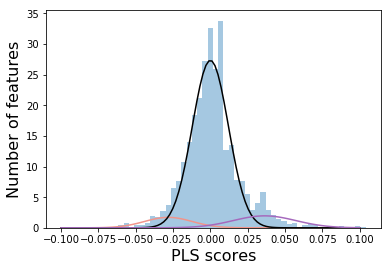

In [4]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(6, 4))
potato_pls = PLSRegression(n_components=1)
potato_pls.fit(X=ctable.values, Y=Y)

potato_spectrum = pd.DataFrame(potato_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

potato_mixture = GaussianMixture(n_components=3, 
                                 means_init=np.array([[-0.05], [0], [0.05]]), 
                                 random_state=0)
potato_mixture.fit(X=potato_spectrum.values)

potato_m = np.ravel(potato_mixture.means_)
potato_s = np.ravel(np.sqrt(potato_mixture.covariances_)) 
potato_w = np.ravel(potato_mixture.weights_)

x = np.linspace(-0.1, 0.1, 100)
sns.distplot(potato_spectrum, norm_hist=True, kde=False, ax=ax)
ax.plot(x, potato_w[0]*norm.pdf(x, potato_m[0], potato_s[0]), red_color)
ax.plot(x, potato_w[1]*norm.pdf(x, potato_m[1], potato_s[1]), '-k')
ax.plot(x, potato_w[2]*norm.pdf(x, potato_m[2], potato_s[2]), purple_color)
ax.set_xlabel('PLS scores', fontsize=16)
ax.set_ylabel('Number of features', fontsize=16)
plt.savefig('../results/figures/figure3_potato_feature_histogram.pdf')

Now given what we have seen, it looks like we can fit pretty solid mixture models.  In addition, the purple peak seems very distinct from the red cultivar type.  With this diagnostic information, we'll apply the thresholds and learn a balance that will quantify the separation between the purple and the other cultivars.

In [5]:
l, r = round_balance(potato_spectrum, means_init=np.array([[-0.05], [0], [0.05]]))

denom = potato_spectrum.loc[potato_spectrum.PLS1 < l]
num = potato_spectrum.loc[potato_spectrum.PLS1 > r]

r, s = num.shape[0], denom.shape[0] 
potato_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) - 
                  np.log(table.loc[:, denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

Now we will perform cross validation to see how generalizable this model is, by performing 4 fold crossvaliation and calculating the AUROC for the test data set.  Note that this is only an indication of how well this dataset can train the partial least squares balances - if the AUC scores are low, then it is an indication that the dataset is suitable.  This could arise for a number of reasons, but likely due to heterogousity, or sample size.

In [6]:
cats = pd.Series(class_purple, index=metadata.index)
res = balance_classify(table+1, cats, num_folds=4, 
                       means_init=np.array([[-0.05], [0], [0.05]]) )
num, denom, rad_balance, cv = res
cv

,Q2,AUROC
0,-83.9924,1
1,-170.994,0.992063
2,-88.2404,0.993421
3,-25.5014,1


In [7]:
cv['AUROC'].mean()

0.99637113617376771

As we can see, the classification accuracy is pretty darn good.  Let's try to visualize the actual separation using histograms.

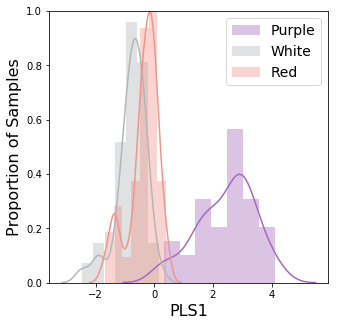

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(rad_balance[class_purple], 
             label='Purple', color=purple_color, bins=7, ax=ax)
sns.distplot(rad_balance[class_white], 
             label='White', color=white_color, bins=7, ax=ax)
sns.distplot(rad_balance[class_red], 
             label='Red', color=red_color, bins=7, ax=ax)
ax.legend(fontsize=14) 
ax.set_ylabel('Proportion of Samples', fontsize=16)
ax.set_xlabel('PLS1', fontsize=16)
ax.set_ylim([0, 1])
plt.savefig('../results/figures/figure3_potato_sample_histogram.pdf')

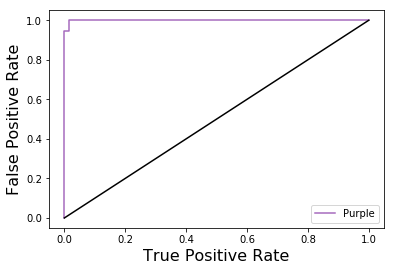

In [9]:
from sklearn.metrics import roc_curve
potato_fpr, potato_tpr, potato_thresholds = roc_curve(y_true=1-cats.astype(int), 
                                                      y_score=rad_balance)

plt.plot(potato_tpr, potato_fpr, label='Purple', c=purple_color)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k')
plt.xlabel('True Positive Rate', fontsize=16)
plt.ylabel('False Positive Rate', fontsize=16)
plt.legend(loc=4)
#plt.savefig('purple_roc_curve.pdf')

In [10]:
from sklearn.metrics import auc
print('Purple vs Others AUC:\t\t', auc(potato_tpr, potato_fpr))

Purple vs Others AUC:		 0.999228395062


In [11]:
from scipy.stats import f_oneway
potato_f, potato_p = f_oneway(potato_balance.loc[class_purple],
                              potato_balance.loc[~class_purple])
print('Purple vs Others \t -- F-statistic: %f \t p-value: \t %E' % (potato_f, potato_p))

Purple vs Others 	 -- F-statistic: 360.643249 	 p-value: 	 6.730523E-36


In [12]:
writer = pd.ExcelWriter('../results/cultivar_color_stats.xlsx')

stats = pd.Series([auc(potato_tpr, potato_fpr), cv['AUROC'].mean(), potato_f, potato_p],
                  index=['AUC', 'AUC_CV', 'F-statistic', 'p-value'])

x = cv['AUROC'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

In [13]:
num.index

Index(['309.1183_344.2704', '659.9844_ 42.5390', '644.0101_  9.6948',
       '266.1640_238.1744', '852.5145_346.6689', '163.0404_251.3158',
       '175.0327_ 28.8505', '853.5183_346.7431',
       '"Massbank:PB006182 Chlorogenic Acid|(1S,3R,4R,5R)-3-[(E)-3-(3,4-dihydroxyphenyl)prop-2-enoyl]oxy-1,4,5-trihydroxycyclohexane-1-carboxylic acid_r2"',
       '293.1231_346.8011',
       ...
       '1021.0408_347.1931', '951.4979_314.8942', '176.1060_ 13.1178',
       '761.3974_319.3164', '833.9083_396.6989', '820.8370_334.4048',
       '690.8504_340.3894', '412.1828_217.2022', '147.0438_212.3061',
       '1491.6421_392.4912'],
      dtype='object', length=327)

In [14]:
denom.index

Index(['118.0869_ 23.9214', 'L-Tyrosine_r29', '147.0485_ 31.3169',
       '165.0600_ 39.0564', '130.0762_ 26.5473', 'Solanidine_r4',
       '132.1028_ 32.7029', 'DL-Indole-3-lactic acid_r2', '706.4515_347.4988',
       '268.1141_ 58.7083',
       ...
       '1501.3200_397.3321', '1502.3228_397.3321', '828.4458_359.4308',
       '875.7659_395.7759', '1139.9724_398.1177', '1501.6551_397.3321',
       '828.6466_358.6367', '1139.5180_410.8208', '323.0804_ 26.0820',
       '309.2039_589.1369'],
      dtype='object', length=2143)

In [32]:
import matplotlib

def rgb2hex(x):
    return '#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255))

num = num.sort_values(by='PLS1')
denom = denom.sort_values(by='PLS1')

f_ids = list(num.index) + list(denom.index) + list(set(potato_spectrum.index) - (set(num.index) | set(denom.index)))

n = len(num.index) 
d = len(denom.index)
o = len(f_ids) - n - d

cmap = matplotlib.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.Normalize(vmin=metadata.cultivar_color.min(), 
                                   vmax=metadata.cultivar_color.max())
metadata = metadata.sort_values(by='cultivar_color')
s_ids = list(metadata.index)
potato_colors = pd.Series([purple_color]*metadata.cultivar_color.value_counts()['Purple'] + 
                          [red_color]*metadata.cultivar_color.value_counts()['Red'] + 
                          [white_color]*metadata.cultivar_color.value_counts()['White'],
                          index=s_ids,
                          name='Samples')

feature_colors = pd.Series([purple_color]*n + [white_color]*d + ['#FDFEFE']*o,
                           index=f_ids, name='Features')

In [39]:
ctable.columns

Index(['182.1049_ 61.8437', '252.1341_ 59.4246', '492.1847_285.2300',
       '199.1070_ 37.1790', '166.0973_821.0212', '307.5840_ 45.8245',
       '864.4501_322.2036', '876.4190_346.7232', '127.0413_146.1455',
       '312.2009_146.5344',
       ...
       '349.1674_229.5044', '119.0498_ 34.7071', '237.1203_157.0224',
       '870.5103_343.3126', '207.0644_ 93.9712', '368.2311_229.1544',
       '300.1640_103.0763', '175.1218_213.4934', '285.1439_ 32.6428',
       '143.0335_ 88.7847'],
      dtype='object', length=2694)

In [38]:
feature_colors.index

Index(['182.1049_ 61.8437', '252.1341_ 59.4246', '492.1847_285.2300',
       '199.1070_ 37.1790', '166.0973_821.0212', '307.5840_ 45.8245',
       '864.4501_322.2036', '876.4190_346.7232', '127.0413_146.1455',
       '312.2009_146.5344',
       ...
       '349.1674_229.5044', '119.0498_ 34.7071', '237.1203_157.0224',
       '870.5103_343.3126', '207.0644_ 93.9712', '368.2311_229.1544',
       '300.1640_103.0763', '175.1218_213.4934', '285.1439_ 32.6428',
       '143.0335_ 88.7847'],
      dtype='object', length=2694)

In [35]:
table.reindex(index=s_ids).index

Index(['BPB3', 'CPP1', 'CPP2', 'SPB2', 'MPB3', 'SPP1', 'RPP1', 'RPP2', 'SPB1',
       'BPP3',
       ...
       'BWA2', 'RWB2', 'CWA1', 'RWB3', 'RWA3', 'MWA3', 'CWB1', 'BWB1', 'RWA2',
       'FWB2'],
      dtype='object', length=108)

In [37]:
metadata.index

Index(['BPB3', 'CPP1', 'CPP2', 'SPB2', 'MPB3', 'SPP1', 'RPP1', 'RPP2', 'SPB1',
       'BPP3',
       ...
       'BWA2', 'RWB2', 'CWA1', 'RWB3', 'RWA3', 'MWA3', 'CWB1', 'BWB1', 'RWA2',
       'FWB2'],
      dtype='object', name='#SampleID', length=108)

In [27]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

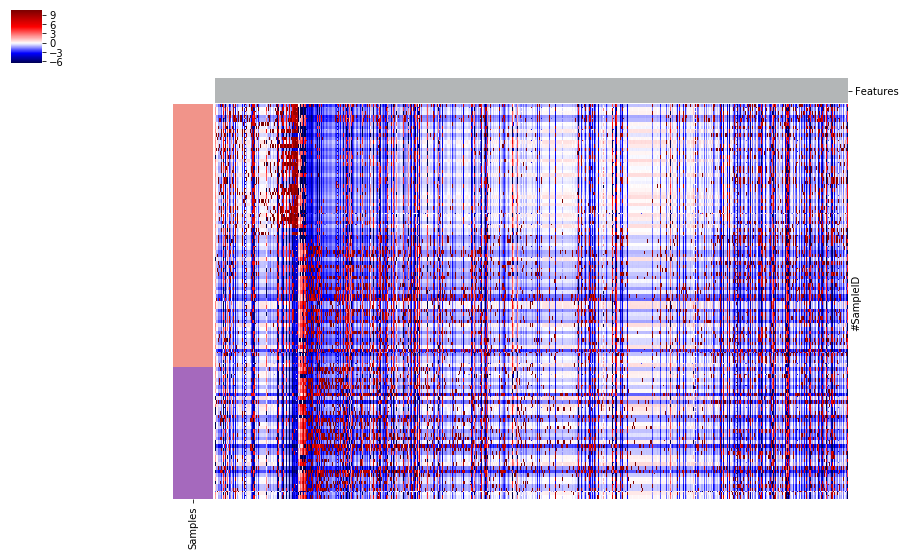

In [17]:
import seaborn as sns

metadata = metadata.sort_values(by='cultivar_color')

ctable = ctable.reindex(columns=f_ids, index=s_ids)

feature_colors = pd.Series([purple_color]*n + [white_color]*d,
                           index=list(num.index) + list(denom.index), name='Features')


G = sns.clustermap(ctable.loc[:, list(num.index)+list(denom.index)], 
                   row_cluster=False, col_cluster=False, 
                   row_colors=potato_colors, 
                   col_colors=feature_colors, cmap='seismic', 
                   norm=MidpointNormalize(midpoint=0),
                   robust=True, figsize=(15, 9))
_ = G.ax_heatmap.set_xticks([])
_ = G.ax_heatmap.set_yticks([])
G.savefig('../results/figure3_potato_heatmap_partial.pdf')

#fig = plt.figure(figsize=(7, 7))
#plt.imshow(ctable.values, aspect='auto', interpolation='nearest', cmap='seismic', norm=MidpointNormalize(midpoint=0))


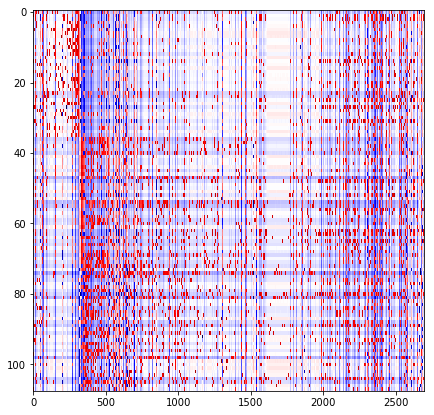

In [28]:
fig = plt.figure(figsize=(7, 7))
ctable = ctable.reindex(columns=f_ids,
                        index=metadata.cultivar_color.sort_values().index)

feature_colors = pd.Series([purple_color]*n + [white_color]*d,
                           index=list(num.index) + list(denom.index), name='Features')
plt.imshow(ctable.values, aspect='auto', interpolation='nearest', cmap='seismic', 
           norm=MidpointNormalize(midpoint=0))


In [42]:
ctable = ctable.reindex(columns=f_ids, index=s_ids)

In [46]:
ctable.loc[:, list(num.index)+list(denom.index)].columns

Index(['182.1049_ 61.8437', '252.1341_ 59.4246', '492.1847_285.2300',
       '199.1070_ 37.1790', '166.0973_821.0212', '307.5840_ 45.8245',
       '864.4501_322.2036', '876.4190_346.7232', '127.0413_146.1455',
       '312.2009_146.5344',
       ...
       '417.1876_ 63.3327', '355.1268_ 97.6479', '712.3648_334.3706',
       'Solanidine_r4', '644.0331_346.4701', '388.1832_439.4843',
       '212.0973_196.0666', '313.1508_209.7020', '602.3292_307.3730',
       '364.0675_ 36.5807'],
      dtype='object', length=2470)

In [48]:
num.index

Index(['182.1049_ 61.8437', '252.1341_ 59.4246', '492.1847_285.2300',
       '199.1070_ 37.1790', '166.0973_821.0212', '307.5840_ 45.8245',
       '864.4501_322.2036', '876.4190_346.7232', '127.0413_146.1455',
       '312.2009_146.5344',
       ...
       '1408.3994_293.4014', '1408.9012_293.6783', '947.2812_303.7350',
       '293.1129_270.7604', '949.2672_284.7604', '963.3027_303.5607',
       '951.2860_296.8252', '965.2932_307.6715', '641.1832_296.5703',
       'Anthocyanin [M+]|Coumaroylated Anthocyanidin Gloucoside|3-(Coum-Rha-Glc)-5-Glc-Petunidin_r26'],
      dtype='object', length=327)

In [49]:
denom.index

Index(['120.0815_ 71.2084', '149.0635_ 71.3135', '103.0546_ 70.0223',
       '166.5085_ 69.9654', '695.3653_294.0873', '166.0889_ 70.8280',
       '167.0894_ 63.3370', '887.2637_311.3506', '1058.6991_380.8330',
       '131.0504_ 64.9624',
       ...
       '417.1876_ 63.3327', '355.1268_ 97.6479', '712.3648_334.3706',
       'Solanidine_r4', '644.0331_346.4701', '388.1832_439.4843',
       '212.0973_196.0666', '313.1508_209.7020', '602.3292_307.3730',
       '364.0675_ 36.5807'],
      dtype='object', length=2143)

In [30]:
metadata.index

Index(['BPB3', 'FPP2', 'SPB3', 'BPB1', 'BPB2', 'FPB3', 'CPP3', 'SPP3', 'CPB1',
       'MPB1',
       ...
       'RWB1', 'CWB3', 'BWA3', 'SWA1', 'FWB3', 'MWA2', 'FWA3', 'SWB1', 'CWA1',
       'FWB2'],
      dtype='object', name='#SampleID', length=108)

# TODO

We will want to have proportion plots here, with the MS annotations.  From this, we'll also want to pull out the interesting differentiating compounds.